In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df.head()

In [ ]:
df.info()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

Here, I have used ResNet for Digit Recognizing. There are two essential blocks of the model
<ol>1.) Identity Block</ol>
<ol>2.) Convolutional Block</ol>

1.) Identity Block<br>
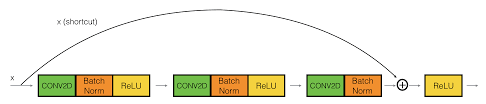

Here the activation from the zeroth layer is added to the output of 3rd layer, before applying the activation.
The function created takes input from previous layer 'X';<br>
F1, F2, F3 are the number of filters for the 1st, 2nd and 3rd convolutional layer.<br>
f is the filter size of the middle layer (i.e 2nd layer)<br>

The output size of the identity block is same as the input size. Because in first and third layers<br>
filter size and strides used are (1,1) and 'valid' padding is applied. Therefore, as per formula<br> 
output_size = ((input_size - 1)/1 - 1) = input_size.<br> 
And 'same' padding is applied in the 2nd layer. Therefore the size remains same.<br>

In [ ]:
def identity_block(X,F1,F2,F3,f):
    X_shortcut = X
    
    X = layers.Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X)
    
    X =X = layers.Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding="same")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X) 
    
    X = layers.Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Add()([X,X_shortcut])
    X = layers.Activation('relu')(X)
    return X

2.) Convolutional Block<br>
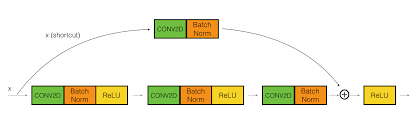<br>
Here the activation from the zeroth layer is first passed through convolutional and batch normalization layer, then added to the output of 3rd layer (before applying the activation).
The function created takes input from previous layer 'X';<br>
F1, F2, F3 are the number of filters for the 1st, 2nd and 3rd convolutional layer.<br>
f is the filter size of the middle layer (i.e 2nd layer)<br>
s is the strides for the convolutional layer used in the shortcut route<br>
The output size of the identity block depends on the stride s of the outer convolutional layer. Because in the outer convolutional layer, filter size and strides used are (1,1) and (s,s) respectively and 'valid' padding is applied. Therefore, as per formula<br> 
output_size = ((input_size - 1)/s - 1)<br> 

Strides 's' is applied for 1st layer in order to match the output of the outer layer.

In [ ]:
def conv_block(X,F1,F2,F3,f,s):
    X_shortcut = X
    
    X = layers.Conv2D(filters=F1,kernel_size=(1,1),strides=(s,s),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X)
    
    X =X = layers.Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding="same")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X) 
    
    X = layers.Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding="valid")(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X_shortcut = layers.Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding="valid")(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=-1)(X_shortcut) 
    
    X = layers.Add()([X,X_shortcut])
    X = layers.Activation('relu')(X)
    return X

In [ ]:
from tensorflow.keras import Model

Following architecture is for the ResNet 50:
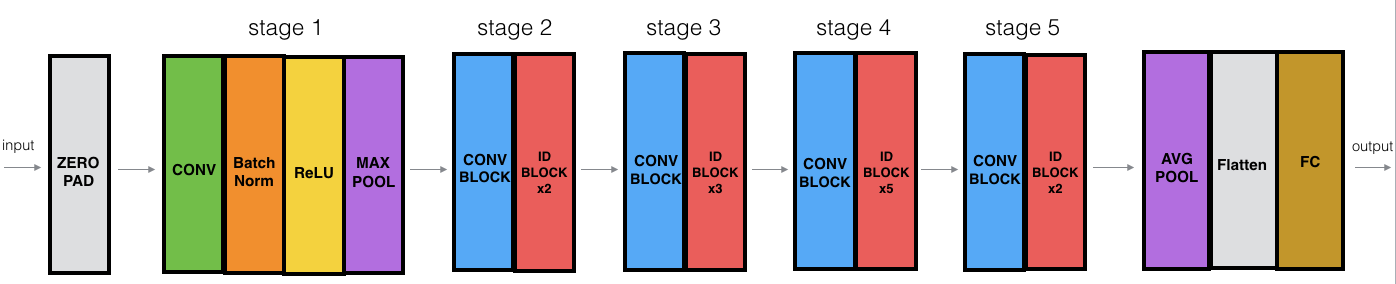

In [ ]:
def ResNet50(input_shape=(28,28,1),classes = 10):
    
    x_input = layers.Input(input_shape)
    
    x = layers.ZeroPadding2D((3,3))(x_input)
    
    x = layers.Conv2D(filters=4,kernel_size=(3,3),strides=(1,1),padding='valid')(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    
    x = conv_block(x,4,4,8,f=3,s=1)
    x = identity_block(x,4,4,8,f=3)
    x = identity_block(x,4,4,8,f=3)
    
    x = conv_block(x,8,8,16,f=3,s=1)
    x = identity_block(x,8,8,16,f=3)
    x = identity_block(x,8,8,16,f=3)
    x = identity_block(x,8,8,16,f=3)

    x = conv_block(x,16,16,32,f=3,s=1)
    x = identity_block(x,16,16,32,f=3)
    x = identity_block(x,16,16,32,f=3)
    x = identity_block(x,16,16,32,f=3)
    x = identity_block(x,16,16,32,f=3)
    x = identity_block(x,16,16,32,f=3)
    
    x = conv_block(x,32,32,64,f=3,s=2)
    x = identity_block(x,32,32,64,f=3)
    x = identity_block(x,32,32,64,f=3)
    
    x = layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(classes,activation='softmax')(x)
    
    model = Model(inputs = x_input,outputs=x)
    
    return model
    

In [ ]:
model = ResNet50((28,28,1),10)
print(model.summary())

In [ ]:
y = df['label']
x = df.drop(columns=['label'])

Here, the 784 pixels are converted to 2D image using np.reshape() function
therefore 42000 X 724 becomes 42000 X 28 X 28 X1

In [ ]:
import matplotlib.pyplot as plt
x_arr = np.zeros((42000,28,28,1))
for i in range(x.shape[0]):
    arr = np.array(x.iloc[i,:])
    arr = arr.reshape((28,28,1))
    x_arr[i] = arr

First 10 Images have been plotted for verifying the results

In [ ]:
count = 1
plt.figure(figsize=(30,30))
for i in range(10):
    plt.subplot(4,3,count)
    count = count + 1
    plt.imshow(x_arr[i])

In [ ]:
print(x_arr.shape)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
x_train,x_test,y_train,y_test = train_test_split(x_arr,y,test_size = 0.1,random_state = 1)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y = encoder.fit_transform(y)
y = np_utils.to_categorical(y)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape,sep=" ")

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,batch_size=20,epochs=10,validation_data = (x_test,y_test))

In [ ]:
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
df_test.head()

In [ ]:
x_arr_test = np.zeros((df_test.shape[0],28,28,1))
for i in range(df_test.shape[0]):
    arr = np.array(df_test.iloc[i,:])
    x_arr_test[i] = arr.reshape((28,28,1))

In [ ]:
ytest_pred = model.predict(x_arr_test)
ytest_pred = np.argmax(ytest_pred,axis=1)

In [ ]:
imageid = np.arange(1,x_arr_test.shape[0]+1)
imageid = imageid.reshape((imageid.shape[0],1))
ytest_pred = ytest_pred.reshape((ytest_pred.shape[0],1))
submission = np.concatenate((imageid,ytest_pred),axis=1)
print(submission)

In [ ]:
pd.DataFrame(submission,columns=['ImageId','Label']).to_csv('submission.csv',index=False)